In [1]:
import pandas as pd
import numpy as np
from joblib import dump, load
import time
import datetime
import operator

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import callbacks

from matplotlib import pyplot as plt

In [2]:
%load_ext tensorboard

### Some useful functions

In [3]:
def get_confusion_matrix(true_pos, false_pos, true_neg, false_neg):
    conf_matrix = np.array([
                            [true_pos, false_pos],
                            [false_neg, true_neg]
                           ])
    
    return pd.DataFrame(conf_matrix, columns=['1', '0'], index=['1', '0'])

In [4]:
def learning_plot(model, metric):
    
    fig = plt.figure()
    
    fig = plt.plot(model.history[metric], color='black')
    fig = plt.plot(model.history['val_'+metric], color='blue')

    plt.title('Changes in {} over training run'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    
    plt.legend(['train', 'val'], loc='upper right')
    
    return fig

In [5]:
def learning_recall(model, positives_flag=True):
    
    if positives_flag:
        recall = [tp / (tp+fn) for tp, fn in zip(model.history['true_positives'], model.history['false_negatives'])]
        val_recall = [tp / (tp+fn) for tp, fn in zip(model.history['val_true_positives'], model.history['val_false_negatives'])]
        recall_type = 'positive'
    else:
        recall = [tn / (tn+fp) for tn, fp in zip(model.history['true_negatives'], model.history['false_positives'])]
        val_recall = [tn / (tn+fp) for tn, fp in zip(model.history['val_true_negatives'], model.history['val_false_positives'])]
        recall_type = 'negative'
        
    fig = plt.figure()
    
    fig = plt.plot(recall, color='black')
    fig = plt.plot(val_recall, color='blue')
    
    plt.title('Changes in {} recall rate over training run.'.format(recall_type))
    plt.xlabel('Epoch')
    plt.ylabel('{} recall rate'.format(recall_type))
    
    return fig

In [6]:
def random_search_models(num_models, input_dims, compile_metrics, seed):
    
    np.random.seed(seed)
    
    all_models = []
    
    for m in range(num_models): 
        
        num_hidden_layers = np.random.randint(1, 11)
        all_models.append(build_model(num_hidden_layers, input_dims, compile_metrics))
    
    return all_models

def build_layers(num_layers, input_dims):

    layers = []
    
    for i in range(num_layers):
        
        num_units = np.random.randint(2, 27)
        reg_val = 10**(-4*np.random.rand())
        if i==0:
            layers.append(Dense(
                                units = num_units,
                                input_dim = input_dims,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
        else:
            layers.append(Dense(
                                units = num_units,
                                activation = 'relu',
                                kernel_regularizer = l2(l2=reg_val)
                               ))
    reg_val = 10**(-4*np.random.rand())
    layers.append(Dense(
                        units = 1,
                        activation = 'sigmoid',
                        kernel_regularizer = l2(l2=reg_val)
                       ))
    return layers

def build_model(num_hidden_layers, input_dims, compile_metrics):

    model = Sequential()
    
    layers = build_layers(num_hidden_layers, input_dims)
    for l in layers:
        model.add(l)
    
    learning_rate = 10**(-4*np.random.rand())
    model.compile(optimizer = Adam(learning_rate), loss='binary_crossentropy', metrics=[compile_metrics])
    
    return model

In [7]:
def get_best_models(model_list, metric, descending, num_models):
    
    m_tuples = []
    for model, history, num in model_list:
        m_tuples.append((model, history, history.history[metric][-1], num))
        
    m_tuples.sort(key=operator.itemgetter(2), reverse=descending)
    
    if num_models:
        return m_tuples[:num_models]
    else:
        return m_tuples

### Load and prepare data

In [8]:
df = pd.read_csv('jazz.csv', sep='|')

In [9]:
# Define features to analyze
features = [
            'danceability',
            'energy',
            'speechiness',
            'acousticness',
            'instrumentalness',
            'liveness',
            'valence',
            'num_samples',
            'end_of_fade_in',
            'loudness',
            'tempo',
            'key',
            'mode',
            'bars_num',
            'bars_duration_var',
            'beats_duration_var',
            'sections_num',
            'sections_duration_mean',
            'sections_duration_var',
            'loudness_var',
            'tempo_var',
            'key_var',
            'mode_var',
            'segments_duration_var',
            'segments_duration_mean',
            'pitches_mean',
            'pitches_var',
            'timbre_mean',
            'timbre_var',
            'tatums_duration_var'
           ]

df = df[features+['label']]

# Shuffle data to ungroup class rows
df = df.sample(frac=1, random_state=12).reset_index(drop=True)

In [10]:
df[df['label']==1].shape

(1648, 31)

Split dataset into training, validation, and test. 60/20/20 gives ~936 positive training samples, and ~312 each of positive validation and test samples. Quite small, but hopefully big enough to be meaningful.

In [11]:
X = df[features].copy()
Y = df['label'].copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    Y, 
                                                    stratify = Y,
                                                    test_size = 0.2,
                                                    random_state = 42
                                                   )

# Start building model

In [12]:
# First fit how to scale data for the model
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

scale_model = pipeline.fit(X_train)
X_train = scale_model.transform(X_train)
X_test = scale_model.transform(X_test)

# Save for later use
dump(scale_model, 'scaler.joblib') 

['scaler.joblib']

In [13]:
logdir = 'logs/scalars/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)

metrics = [
           tfk.metrics.Precision(),
           tfk.metrics.TruePositives(),
           tfk.metrics.TrueNegatives(),
           tfk.metrics.FalsePositives(),
           tfk.metrics.FalseNegatives(),
           tfk.metrics.AUC(curve='PR')
          ]

models = random_search_models(num_models=100, input_dims=len(features), compile_metrics=metrics, seed=42)

model_list = []

for i, model in enumerate(models):

    training_history = model.fit(
                                 X_train,
                                 y_train,
                                 batch_size = 128,
                                 verbose = 0,
                                 epochs = 500,
                                 validation_split = 0.2,
                                 callbacks=[callbacks.TensorBoard(log_dir=logdir+'-'+str(i+1))],
                                )
    model_list.append((model, training_history, i+1))
    
    print('Average validation loss for model ', str(i+1), ': ', np.average(training_history.history['val_loss']))

Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Average validation loss for model  1 :  1.074791887283325
Average validation loss for model  2 :  0.770148980140686
Average validation loss for model  3 :  0.7833348174095154
Average validation loss for model  4 :  0.7044922070503234
Average validation loss for model  5 :  0.6850508999824524
Average validation loss for model  6 :  0.736177613735199
Average validation loss for model  7 :  1.0503609644174576
Average validation loss for model  8 :  0.537205762386322
Average validation loss for model  9 :  0.5905480197668076
Average validation loss for model  10 :  0.6816741652488708
Average validation loss for model  11 :  0.5224599255919457
Average validation loss for model  12 :  0.7585353825092316
Average validation loss for model  13 :  0.7599738101959228
Average validation loss for model  14 :  0.5279103149175643
Average validation loss for model  15 :  0.7629369660615921
Average validation loss for model  16 :  

Average validation loss for model  34 :  1.281163642525673
Average validation loss for model  35 :  0.7041807556152344
Average validation loss for model  36 :  0.6822975541353226
Average validation loss for model  37 :  0.6836830507516861
Average validation loss for model  38 :  0.6053261585235595
Average validation loss for model  39 :  0.6829038876295089
Average validation loss for model  40 :  0.4994904072880745
Average validation loss for model  41 :  1.1581480093002319
Average validation loss for model  42 :  0.560954592704773
Average validation loss for model  43 :  0.981311800122261
Average validation loss for model  44 :  0.7262413486242294
Average validation loss for model  45 :  0.6679092574119568
Average validation loss for model  46 :  0.6817970708608627
Average validation loss for model  47 :  0.5215190678834916
Average validation loss for model  48 :  0.5325997664928436
Average validation loss for model  49 :  0.4933627819418907
Average validation loss for model  50 :  0.

Average validation loss for model  69 :  0.9522357105016709
Average validation loss for model  70 :  0.6680014578104019
Average validation loss for model  71 :  1.0056280450820922
Average validation loss for model  72 :  0.6816249704360962
Average validation loss for model  73 :  0.6828915566205979
Average validation loss for model  74 :  0.6902096041440964
Average validation loss for model  75 :  0.6819925225973129
Average validation loss for model  76 :  0.6829729088544846
Average validation loss for model  77 :  0.6523498187065124
Average validation loss for model  78 :  0.6188367758989334
Average validation loss for model  79 :  0.6925904395580291
Average validation loss for model  80 :  0.6847021640539169
Average validation loss for model  81 :  0.6844090280532837
Average validation loss for model  82 :  0.5119225209355355
Average validation loss for model  83 :  0.5494461736679077
Average validation loss for model  84 :  0.6822003543376922
Average validation loss for model  85 : 

In [34]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 6736), started 0:02:29 ago. (Use '!kill 6736' to kill it.)

In [109]:
# Get five best models to evaluate on Tensorboard
model_list_sorted = get_best_models(model_list, 'val_loss', descending=False, num_models=5)

In [200]:
model_list_sorted[4]

(<tensorflow.python.keras.engine.sequential.Sequential at 0x1ef808feb20>,
 0.4967952072620392,
 40)

In [201]:
# Selecting model from top 5 lowest validation loss with highest AUC 
best_model = model_list_sorted[4][0]
best_history = model_list_sorted[4][1]

In [202]:
best_model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 22)                682       
_________________________________________________________________
dense_269 (Dense)            (None, 1)                 23        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


# Evaluate model on validation set

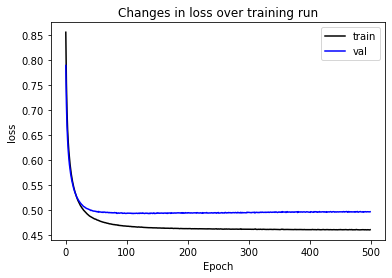

In [203]:
learning_plot(best_history, 'loss')

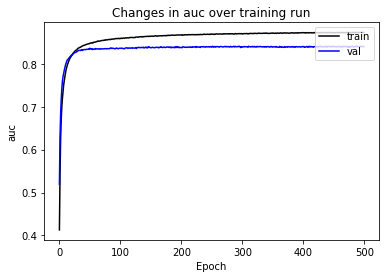

In [204]:
learning_plot(best_history, 'auc')

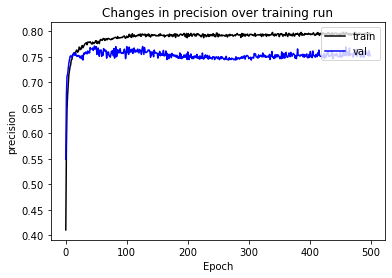

In [205]:
learning_plot(best_history, 'precision')

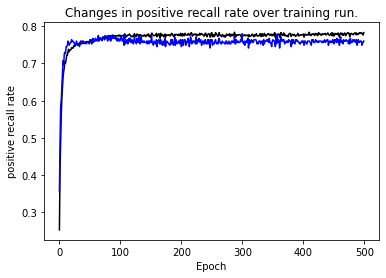

In [206]:
learning_recall(best_history, True)

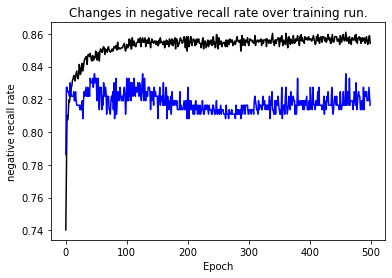

In [207]:
learning_recall(best_history, False)

In [208]:
loss = best_history.history['loss'][-1]
val_loss = best_history.history['val_loss'][-1]
print('Loss for training set is {}, while loss for validation set is {}. This gives a difference of {}'\
      .format(
              round(loss,4),
              round(val_loss,4), 
              round(val_loss-loss, 4))
             )

Loss for training set is 0.4609, while loss for validation set is 0.4968. This gives a difference of 0.0359


In [209]:
auc = best_history.history['auc'][-1]
val_auc = best_history.history['val_auc'][-1]
print('AUC for training set is {}, while AUC for validation set is {}. This gives a difference of {}'\
      .format(round(auc, 2), round(val_auc, 2), round(auc-val_auc,2)))

AUC for training set is 0.87, while AUC for validation set is 0.84. This gives a difference of 0.03


In [210]:
true_positives_val = best_history.history['val_true_positives'][-1]
false_positives_val = best_history.history['val_false_positives'][-1]
true_negatives_val = best_history.history['val_true_negatives'][-1]
false_negatives_val = best_history.history['val_false_negatives'][-1]

val_conf_matrix = get_confusion_matrix(
                                       true_positives_val,
                                       false_positives_val,
                                       true_negatives_val,
                                       false_negatives_val
                                      )

print('Confusion_matrix:\n{}'.format(val_conf_matrix))

Confusion_matrix:
       1      0
1  203.0   67.0
0   64.0  298.0


In [211]:
print('True recall rate is {}'\
      .format(round(val_conf_matrix.loc['1', '1']/(val_conf_matrix.loc['1', '1']+val_conf_matrix.loc['0', '1']),2)))
print('Precision is {}'.format(best_history.history['val_precision'][-1]))

True recall rate is 0.76
Precision is 0.7518518567085266


Looks very promising on validation set! Let's check test set

In [212]:
loss_test, precision_test, true_positives_test, true_negatives_test, false_positives_test, false_negatives_test, auc_test = best_model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 1ms/step - loss: 0.5257 - precision: 0.7147 - true_positives: 248.0000 - true_negatives: 361.0000 - false_positives: 99.0000 - false_negatives: 82.0000 - auc: 0.8043


In [213]:
print('AUC for test set is {}.'.format(round(auc_test,2)))

AUC for test set is 0.8.


In [214]:
confusion_matrix = get_confusion_matrix(
                                        true_positives_test,
                                        false_positives_test,
                                        true_negatives_test,
                                        false_negatives_test
                                       )

In [215]:
print(confusion_matrix)

       1      0
1  248.0   99.0
0   82.0  361.0


In [216]:
print(
      'True recall rate is {}'\
      .format(round(
                    confusion_matrix.loc['1', '1']/
                    (confusion_matrix.loc['1', '1']+confusion_matrix.loc['0', '1']),
                    2
                   )
             )
     )
print('Precision is {}'.format(round(precision_test,2)))

True recall rate is 0.75
Precision is 0.71


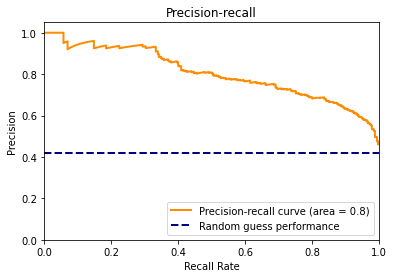

In [217]:
from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight

# sample_weights = compute_sample_weight(class_weight='balanced', y=y_test)
random_pr = y_test.value_counts().iloc[1] / len(y_test)

predictions = best_model.predict(X_test)
precision, recall, thresholds = metrics.precision_recall_curve(y_test, predictions)
pr_auc = metrics.auc(recall, precision)

plt.figure()
lw = 2
plt.plot(
         recall, 
         precision, 
         color = 'darkorange',
         lw = lw, 
         label = 'Precision-recall curve (area = {})'.format(round(pr_auc,2))
        )
plt.plot([0, 1], [random_pr, random_pr], color='navy', lw=lw, linestyle='--', label='Random guess performance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall Rate')
plt.ylabel('Precision')
plt.title('Precision-recall')
plt.legend(loc = 'lower right')

# Save model

In [218]:
best_model.save('jazz_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: jazz_model\assets
